<a href="https://colab.research.google.com/github/sakshijain23/Rainfall-prediction-using-k-means-algorithm/blob/master/Rainfall_sem2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
pip install netCDF4

**To plot the file**

In [0]:
import os, sys, netCDF4, matplotlib
#matplotlib.use(‘Agg’)
import numpy as N
#import json
#from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from pylab import linspace
from scipy import interpolate
from matplotlib.colors import LinearSegmentedColormap
'''
Run from command-line like this:
$ python plotCloudScene.py matched-airs.aqua_cloudsat-v3.2-2006.10.07.240_airs.nc test.png
$ display test.png
'''
def cmap_discretize(cmap, n):
 """Return a discrete colormap from the continuous colormap cmap.
 cmap: colormap instance, eg. cm.jet.
 n: number of colors.
 Example
 x = resize(arange(100), (5,100))
 djet = cmap_discretize(cm.jet, 5)
 imshow(x, cmap=djet)
 """
 cdict = cmap._segmentdata.copy()
 # n colors
 colors_i = linspace(0,1.,n)
 # n+1 indices
 indices = linspace(0,1.,n+1)
 for key in ('red','green','blue'):
 # Find the n colors
     D = N.array(cdict[key])
     I = interpolate.interp1d(D[:,0], D[:,1])
     colors = I(colors_i)
     # Place these colors at the correct indices.
     A = N.zeros((n+1,3), float)
     A[:,0] = indices
     A[1:,1] = colors
     A[:-1,2] = colors
     # Create a tuple for the dictionary.
     L = []
     for l in A:
         L.append(tuple(l))
         cdict[key] = tuple(L)
 # Return colormap object.
 return LinearSegmentedColormap('colormap',cdict,1024)
#set input and output files
ncFile = sys.argv[1]
plotFile = sys.argv[2]

ncFile="matched-airs.aqua_cloudsat-v3.2-2006.07.01.074_airs.nc"
f = netCDF4.Dataset(ncFile)
print(f)
fig = plt.figure()
fig.clf()
cloud_scen = f.groups['CloudSat'].groups['CLDCLASS'].variables['cloud_scenario'][:]
height = f.groups['CloudSat'].groups['GEOPROF'].variables['Height'][:]
csLat = f.groups['CloudSat'].groups['GEOPROF'].variables['Latitude'][:]
radiances = f.groups['AIRS'].groups['Radiances'].variables['radiances'][:]
l1bLat = f.groups['AIRS'].groups['Radiances'].variables['Latitude'][:]
#get cloudsat latitude values range
csLat_range = list(set(csLat.flatten().tolist()))
#print(csLat_range)
#csLat_range.sort()
#build cloudsat lat array with same shape as cloud_scenario
newCsLat = N.zeros(cloud_scen.shape)
for i in range(newCsLat.shape[2]): newCsLat[:,:,i] = csLat
#get cloud type bits (bits 1-4, little-endian)
cloud_scen_shift = N.right_shift(N.array(cloud_scen), 1) & int('1111', 2)
cloudTypes = {
 '0000': 'clear',
 '0001': 'Ci',
 '0010': 'As',
 '0011': 'Ac',
 '0100': 'St',
 '0101': 'Sc',
 '0110': 'Cu',
 '0111': 'Ns',
 '1000': 'DC'
}
#plot
sp = fig.add_subplot(111)
csPlot = sp.scatter(newCsLat.flatten(), height.flatten(),
 c=cloud_scen_shift.flatten(),
 vmin=int('0000', 2),
 vmax=int('1000', 2),
 edgecolors='none',
 cmap=cmap_discretize(cm.gist_ncar_r, 9))
#set x(lat) and y(height) limits

if csLat.max() > 90: sp.set_xlim(csLat.min(), csLat_range[-2])
else: sp.set_xlim(csLat.min(), csLat.max())
sp.set_ylim(0, height.max())

#set plot attrs
sp.set_xlabel('CloudSat Latitude')
sp.set_ylabel('CloudSat Height (m)')
plt.title("Cloud Scene")
cb = plt.colorbar(csPlot, ticks=range(9)) #set ticks
cb.ax.set_yticklabels([cloudTypes[N.binary_repr(i, 4)] for i in range(9)]) #set tick labels

#write file
fig.savefig('figure.jpg')
plt.close(fig)



<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    title: AIRS-CloudSat matchups for AIRS granule AIRS.2006.07.01.074.L2.RetStd.v5.0.14.0.G07290015425.hdf (AIRS vars)
    PRODUCTIONDATE: 201208141122
    CloudSatGranules: 2006182063635_00931_CS_2B-GEOPROF_GRANULE_P_R04_E00.hdf
    RANGEBEGINNINGDATE: 2006-07-01
    RANGEBEGINNINGTIME: 07:23:25
    RANGEENDINGDATE: 2006-07-01
    RANGEENDINGTIME: 07:29:25
    NORTHBOUNDINGCOORDINATE: 16.0314807891846
    SOUTHBOUNDINGCOORDINATE: -7.4026951789856
    EASTBOUNDINGCOORDINATE: 101.072952270508
    WESTBOUNDINGCOORDINATE: 81.2775192260742
    IDENTIFIER_PRODUCT_DOI: 10.5067/MEASURES/WVCC/DATA203
    IDENTIFIER_PRODUCT_DOI_AUTHORITY: http://dx.doi.org/
    dimensions(sizes): airs_idx(144)
    variables(dimensions): 
    groups: AIRS, CloudSat


**Kmeans clustering to find the related clouds**

In [0]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
import cv2
from collections import Counter
from skimage.color import rgb2lab, deltaE_cie76
import os

In [0]:
def RGB2HEX(color):
    return "#{:02x}{:02x}{:02x}".format(int(color[0]), int(color[1]), int(color[2]))

def get_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

**Pie Plot To show the percentage**

[array([254.06135224, 250.81046771, 254.16162856]), array([233.52540136, 100.83769518, 201.60567407]), array([192.9280175 , 187.4386558 , 195.74130046]), array([ 66.55356539,  11.25549172, 240.39810747]), array([53.07024664, 46.39119575, 51.60817983]), array([ 32.44397759, 210.02591036, 181.60014006]), array([123.93900251, 121.95191963, 123.15357015]), array([136.84073014,  13.19506084,   6.85289907]), array([168.25847458, 233.72881356,  22.87288136])]


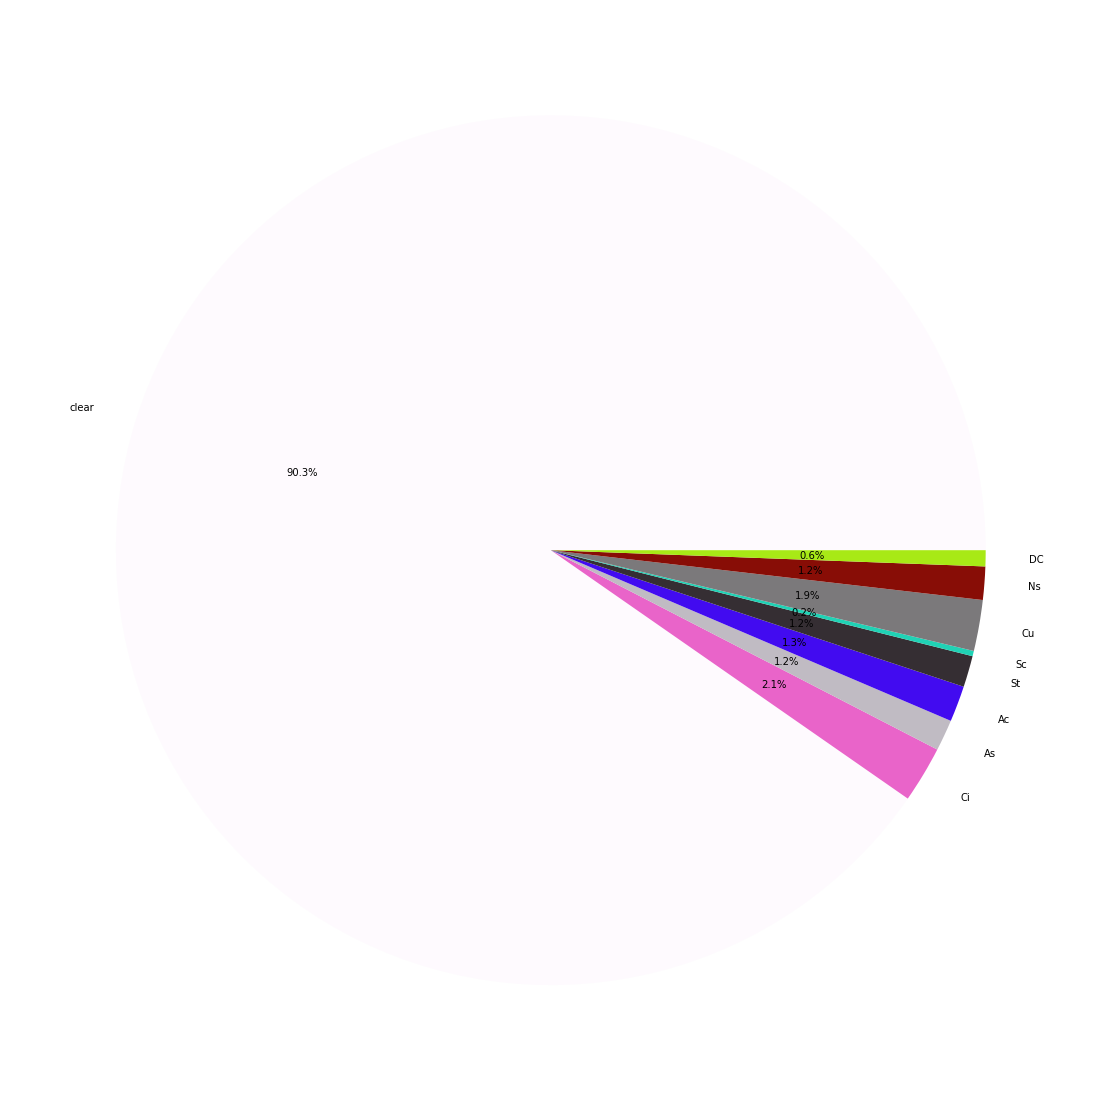

In [0]:
image = cv2.imread('figure.jpg')
modified_image = cv2.resize(image, (600,400), interpolation = cv2.INTER_AREA)
modified_image = modified_image.reshape(modified_image.shape[0]*modified_image.shape[1], 3)

clf = KMeans(n_clusters = 9)
labels = clf.fit_predict(modified_image)

counts = Counter(labels)

center_colors = clf.cluster_centers_
# We get ordered colors by iterating through the keys
ordered_colors = [center_colors[i] for i in counts.keys()]
hex_colors = [RGB2HEX(ordered_colors[i]) for i in counts.keys()]
rgb_colors = [ordered_colors[i] for i in counts.keys()]

if (True):
    plt.figure(figsize = (20, 20))
    plt.pie(counts.values(), labels = cloudTypes.values(), colors = hex_colors,autopct='%.1f%%')

print(rgb_colors)

**Dictionary of showing percentage of different clouds**

In [0]:
New_list=list(counts.values())
s = sum(counts.values())
percentage_cloud={}
#print(cloudTypes.values())
j=0
for i in cloudTypes.values():
    percentage_cloud[i]=((New_list[j]/s)*100)
    j+=1
print(percentage_cloud)

{'clear': 90.325, 'Ci': 2.09625, 'As': 1.16125, 'Ac': 1.3345833333333332, 'St': 1.1641666666666666, 'Sc': 0.19666666666666666, 'Cu': 1.8941666666666666, 'Ns': 1.2329166666666667, 'DC': 0.5950000000000001}


Getting variables


In [0]:
import pandas as ps
X=ps.read_csv("result_1.csv")
rainfall_data=ps.read_csv("y_1.csv")
#print(rainfall_data)
print(X.head())
print(len(X))
print(len(rainfall_data))

           0         1         2         3         4         5
0  89.257083  2.305625  1.414271  1.426250  1.565208  0.408542
1  88.962292  2.429688  1.460208  1.446458  1.960208  0.472813
2  86.561042  2.396354  1.612500  1.508125  3.786875  0.380729
3  90.735729  1.950625  1.258750  1.479062  0.910521  0.820833
4  89.196042  2.344896  1.498854  1.390313  2.216979  0.423229
521
521


NEURAL MODEL

In [0]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV


In [0]:

scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()
scaler_x.fit(X)
xscale=scaler_x.transform(X)
scaler_y.fit(rainfall_data)
yscale=scaler_y.transform(rainfall_data)
X_train, X_test, y_train, y_test = train_test_split(xscale, yscale,random_state=42)
model = Sequential()
model.add(Dense(32, input_dim=6, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(128, activation = 'relu'))
model.add(Dense(64, activation = 'relu'))
model.add(Dense(1, activation='linear'))
model.summary()

model.compile(loss='mse',optimizer="adam",metrics=["accuracy",'mae']) 
history = model.fit(X_train, y_train,epochs=1000,verbose=1, validation_split=0.25)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 32)                224       
_________________________________________________________________
dense_6 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_7 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_8 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 65        
Total params: 18,977
Trainable params: 18,977
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
10/10 [==============================] - 0s 15ms/step - loss: 0.0069 - accuracy: 0.3562 - mae: 0.0556 -

PLOT OF ACCURACY AND LOSS

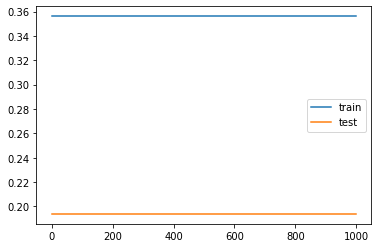

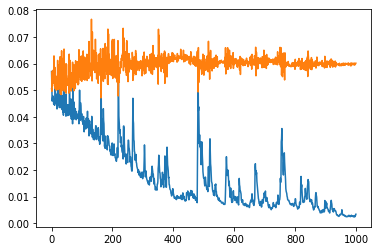

In [0]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()
plt.plot(history.history['mae'], label='train')
plt.plot(history.history['val_mae'], label='test')
plt.show()

predict

In [0]:
from sklearn.metrics import mean_absolute_error,mean_squared_error
pred = model.predict(X_test)
mean_absolute_error(pred,y_test)

0.06556425663948928